In [46]:
import pandas as pd
import numpy as np
import datetime as dt


data = pd.read_csv('C:/Users/neeli/Desktop/Glassdoor/full_data.csv')

print(data['apply'].value_counts())

data['search_date_pacific'] = pd.to_datetime(data['search_date_pacific'], format='%Y-%m-%d').dt.date
data['city_match'] = data['city_match'].astype('category')
oneHotEncoding = pd.get_dummies(data['city_match'], prefix = 'city_match', drop_first = True)
data = pd.concat([data, oneHotEncoding], axis = 1)
data = data.drop('city_match', axis = 1)

## Adding user-interest weightage
user_item_interest = pd.pivot_table(data[['u_id','mgoc_id','apply']], index = ['u_id','mgoc_id'],
                                    columns=['apply'], aggfunc = len).reset_index()
user_item_interest['Ratio'] = user_item_interest[0]/user_item_interest[1]
user_item_interest = user_item_interest[user_item_interest[1] >= user_item_interest[0]].reset_index(drop = True)
user_item_interest['key'] = user_item_interest['u_id'].map(str) + user_item_interest['mgoc_id'].map(str)
user_item_interest['User_Item_Weightage'] = 1

## Adding user weightage
user = pd.pivot_table(data[['u_id','apply']], index = ['u_id'], columns = ['apply'], aggfunc = len).reset_index()
user['Ratio'] = user[0]/user[1]
user = user[user[1] >= user[0]]
user['User_Weightage'] = 1
data['key'] = data['u_id'].map(str) + data['mgoc_id'].map(str)
data = data.merge(user_item_interest[['key','User_Item_Weightage']], on = 'key', how = 'outer')
data = data.merge(user[['u_id','User_Weightage']], on = 'u_id', how = 'outer')
data = data.fillna(0)

#data['User_Item_Weightage']=data['User_Item_Weightage'].astype('category')
#data['User_Weightage']=data['User_Weightage'].astype('category')
#data['apply']=data['apply'].astype('category')

data_train = data[data['search_date_pacific'] < dt.date(2018,1,27)]
data_test = data[data['search_date_pacific'] > dt.date(2018,1,26)]

0    1092887
1     108003
Name: apply, dtype: int64


In [47]:
## Model evaluation 
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn import metrics

def ModelEvaluation(modelname,data_test,y_pred,y_pred_prob):
    metric_auc=roc_auc_score(data_test[y_features],y_pred)
    print(classification_report(data_test[y_features], y_pred))
    c_matrix = confusion_matrix(data_test[y_features], y_pred)
    print('Printing Confusion Matrix...')
    print(c_matrix)

    fpr, tpr, thresholds = roc_curve(np.array(data_test[y_features]), y_pred_prob)
    
    AUC_score=metrics.auc(fpr, tpr)
    print('AUC Score..')
    print(AUC_score)
    
    print('Classification Accuracy...')
    print(metrics.accuracy_score(data_test[y_features], y_pred))
    plt.figure()
    plt.plot(fpr, tpr, label=modelname+' (area = %0.2f)' % AUC_score)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('AUC')
    plt.legend(loc="lower right")
    plt.show()

In [48]:
from sklearn.utils import resample

data_apply0 = data_train[data_train['apply'] == 0]
data_apply1 = data_train[data_train['apply'] == 1]

## 1. Over sample minority
#data_oversample=resample(data_apply1,replace=True,n_samples=len(data_apply0),random_state=10)
#data_train=pd.concat([data_oversample,data_apply0],axis=0)

## 2.  Under sample Majority
data_undersample = resample(data_apply0, replace=True, n_samples = len(data_apply1), random_state = 10)
data_train = pd.concat([data_undersample, data_apply1], axis = 0)

# print(data_train['apply'].value_counts())

## 3. Oversampling by SMOTE 
# from imblearn.over_sampling import SMOTE 

# x_features=['title_proximity_tfidf', 'description_proximity_tfidf',
#        'main_query_tfidf', 'query_jl_score', 'query_title_score',
#        'city_match_0.0','city_match_1.0', 'job_age_days','User_Item_Weightage','User_Weightage']



# y_features=['apply']
# sm = SMOTE(random_state=10)
# X_res, y_res = sm.fit_sample(data_train[x_features], data_train[y_features].values.ravel())

# print('SMOTE-d Shape..')
# print(np.bincount(y_res))

# x_train=pd.DataFrame(X_res,columns=x_features)
# y_train=pd.DataFrame(y_res,columns=y_features)
# data_train=pd.concat([x_train,y_train],axis=1)

In [49]:
data_train.columns

Index(['title_proximity_tfidf', 'description_proximity_tfidf',
       'main_query_tfidf', 'query_jl_score', 'query_title_score',
       'job_age_days', 'apply', 'search_date_pacific', 'u_id', 'mgoc_id',
       'city_match_0.0', 'city_match_1.0', 'key', 'User_Item_Weightage',
       'User_Weightage'],
      dtype='object')

In [50]:
## Get Important Features using RF

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

x_features = ['title_proximity_tfidf', 'description_proximity_tfidf',
       'main_query_tfidf', 'query_jl_score', 'query_title_score',
       'city_match_0.0','city_match_1.0', 'job_age_days','User_Item_Weightage','User_Weightage']

y_features = ['apply']

forest = RandomForestClassifier(n_estimators = 20)
forest.fit(data_train[x_features], data_train[y_features].values.ravel())

#y_pred=forest.predict_proba(data_test[x_features])
importances = forest.feature_importances_


std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(data_train[x_features].shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

print(sorted(zip(map(lambda x: round(x, 4), forest.feature_importances_), x_features), 
             reverse=True))

#print(roc_auc_score(data_test[y_features],y_pred))

Feature ranking:
1. feature 4 (0.225896)
2. feature 3 (0.193480)
3. feature 8 (0.183496)
4. feature 2 (0.128133)
5. feature 7 (0.097361)
6. feature 1 (0.070928)
7. feature 0 (0.059460)
8. feature 9 (0.023704)
9. feature 6 (0.008970)
10. feature 5 (0.008571)
[(0.22589999999999999, 'query_title_score'), (0.19350000000000001, 'query_jl_score'), (0.1835, 'User_Item_Weightage'), (0.12809999999999999, 'main_query_tfidf'), (0.0974, 'job_age_days'), (0.070900000000000005, 'description_proximity_tfidf'), (0.059499999999999997, 'title_proximity_tfidf'), (0.023699999999999999, 'User_Weightage'), (0.0089999999999999993, 'city_match_1.0'), (0.0086, 'city_match_0.0')]


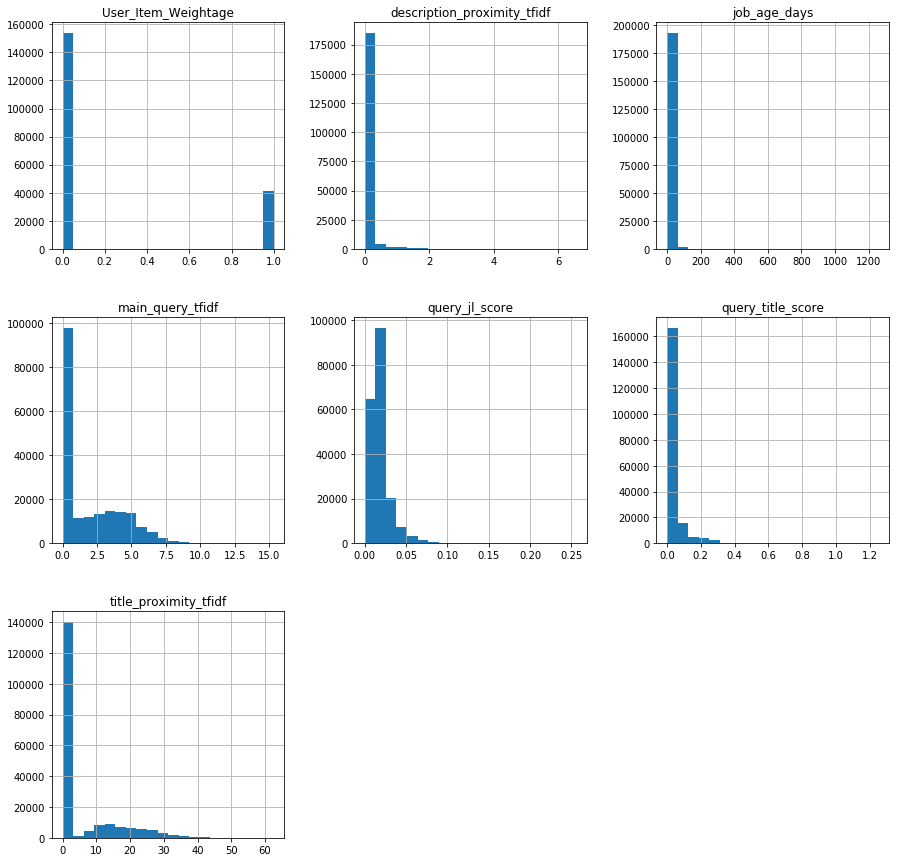

In [51]:
# Takinng a look at the distribution of all feature values
x_important_features = ['title_proximity_tfidf', 'description_proximity_tfidf',
       'main_query_tfidf', 'query_jl_score', 'query_title_score', 'job_age_days','User_Item_Weightage']

data_train_hist =  data_train[x_important_features]
data_train_hist.hist(bins=20, figsize=(15,15))
plt.show()

             precision    recall  f1-score   support

          0       0.94      0.63      0.75    105940
          1       0.14      0.60      0.23     10586

avg / total       0.87      0.63      0.71    116526

Printing Confusion Matrix...
[[66744 39196]
 [ 4204  6382]]
AUC Score..
0.627988996673
Classification Accuracy...
0.627550932839


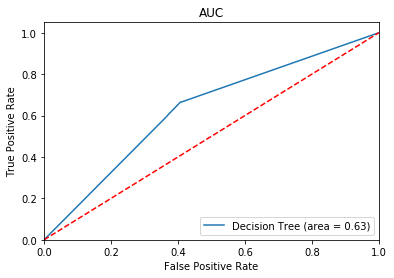

In [52]:
## Algorithm - 1 - Decision Tree - Using under sampled majority class
from sklearn import tree

modelname='Decision Tree'

x_features=['title_proximity_tfidf', 'description_proximity_tfidf',
       'main_query_tfidf', 'query_jl_score', 'query_title_score',
       'city_match_0.0','city_match_1.0', 'job_age_days','User_Item_Weightage','User_Weightage']

x_important_features = ['title_proximity_tfidf', 'description_proximity_tfidf',
       'main_query_tfidf', 'query_jl_score', 'query_title_score', 'job_age_days','User_Item_Weightage']

y_features=['apply']

#dt = tree.DecisionTreeClassifier(criterion='gini')
## AUC Score 0.51
dt = tree.DecisionTreeClassifier(criterion='entropy')

dt.fit(data_train[x_important_features], data_train[y_features]) 
y_pred = dt.predict(data_test[x_important_features])
y_pred_prob=dt.predict_proba(data_test[x_important_features])[:, 1]
ModelEvaluation(modelname,data_test,y_pred,y_pred_prob)

             precision    recall  f1-score   support

          0       0.95      0.74      0.83    105940
          1       0.19      0.63      0.30     10586

avg / total       0.88      0.73      0.79    116526

Printing Confusion Matrix...
[[78603 27337]
 [ 3969  6617]]
AUC Score..
0.742368992679
Classification Accuracy...
0.731338928651


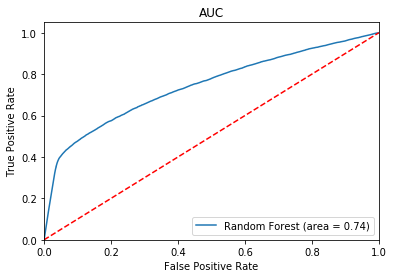

In [53]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV


# param_test = { 
#     'n_estimators': [200, 700],
#     'max_features': ['auto', 'sqrt', 'log2']
# }

# forest = GridSearchCV(estimator =  RandomForestClassifier(max_features = 'sqrt', 
#                                                           oob_score = True, n_estimators = 200), 
#                    param_grid = param_test, scoring = 'roc_auc', n_jobs = 4, iid = False, cv = 10)

modelname = 'Random Forest'

x_features=['title_proximity_tfidf', 'description_proximity_tfidf',
       'main_query_tfidf', 'query_jl_score', 'query_title_score',
       'city_match_0.0','city_match_1.0', 'job_age_days','User_Item_Weightage','User_Weightage']

x_important_features = ['title_proximity_tfidf', 'description_proximity_tfidf',
       'main_query_tfidf', 'query_jl_score', 'query_title_score', 'job_age_days','User_Item_Weightage']

y_features=['apply']

forest = RandomForestClassifier(n_jobs = -1, max_features = 'sqrt', oob_score = True, n_estimators = 200)
forest.fit(data_train[x_important_features], data_train[y_features].values.ravel())
y_pred = forest.predict(data_test[x_important_features])
y_pred_prob = forest.predict_proba(data_test[x_important_features])[:, 1]
ModelEvaluation(modelname, data_test, y_pred, y_pred_prob)

             precision    recall  f1-score   support

          0       0.95      0.88      0.91    105940
          1       0.30      0.52      0.38     10586

avg / total       0.89      0.84      0.86    116526

Printing Confusion Matrix...
[[92796 13144]
 [ 5048  5538]]
AUC Score..
0.752734239757
Classification Accuracy...
0.843880335719


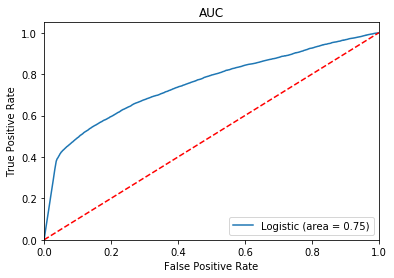

In [54]:
## Algorithm - 3 - Under Sampling with Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

modelname='Logistic'
logreg = LogisticRegression(random_state=10)

x_features=['title_proximity_tfidf', 'description_proximity_tfidf',
       'main_query_tfidf', 'query_jl_score', 'query_title_score',
       'city_match_0.0','city_match_1.0', 'job_age_days','User_Item_Weightage','User_Weightage']

x_important_features = ['title_proximity_tfidf', 'description_proximity_tfidf',
       'main_query_tfidf', 'query_jl_score', 'query_title_score', 'job_age_days','User_Item_Weightage']


y_features=['apply']

forest = logreg.fit(data_train[x_important_features], data_train[y_features].values.ravel())
y_pred=forest.predict(data_test[x_important_features])
y_pred_prob=forest.predict_proba(data_test[x_important_features])[:, 1]
ModelEvaluation(modelname,data_test,y_pred,y_pred_prob)

             precision    recall  f1-score   support

          0       0.95      0.81      0.87    105940
          1       0.23      0.59      0.34     10586

avg / total       0.89      0.79      0.82    116526

Printing Confusion Matrix...
[[85521 20419]
 [ 4323  6263]]
AUC Score..
0.755199286329
Classification Accuracy...
0.787669704615


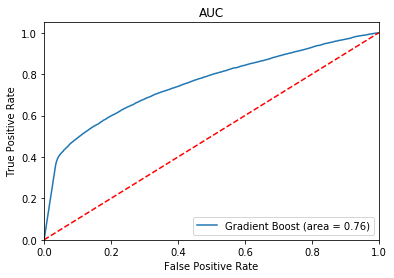

In [25]:
## Algorithm - 4 - Gradient Boost
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

param_test = {}

grd = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate = 0.5, min_samples_leaf = 50, max_depth = 8, 
                                n_estimators = 50, min_samples_split = 500, max_features = 'sqrt', subsample = 0.8, random_state = 10), 
                   param_grid = {}, scoring = 'roc_auc', n_jobs = 4, iid = False, cv = 10)

x_features = ['title_proximity_tfidf', 'description_proximity_tfidf',
       'main_query_tfidf', 'query_jl_score', 'query_title_score',
       'city_match_0.0','city_match_1.0', 'job_age_days','User_Item_Weightage','User_Weightage']

x_important_features = ['title_proximity_tfidf', 'description_proximity_tfidf',
       'main_query_tfidf', 'query_jl_score', 'query_title_score', 'job_age_days','User_Item_Weightage']


y_features = ['apply']
modelname = 'Gradient Boost'

grd.fit(data_train[x_important_features], data_train[y_features].values.ravel()) 
y_pred = grd.predict(data_test[x_important_features])
y_pred_prob = grd.predict_proba(data_test[x_important_features])[:, 1]
ModelEvaluation(modelname,data_test,y_pred,y_pred_prob)

             precision    recall  f1-score   support

          0       0.95      0.82      0.88    105940
          1       0.24      0.59      0.35     10586

avg / total       0.89      0.80      0.83    116526

Printing Confusion Matrix...
[[86578 19362]
 [ 4305  6281]]
AUC Score..
0.762421316088
Classification Accuracy...
0.796895113537


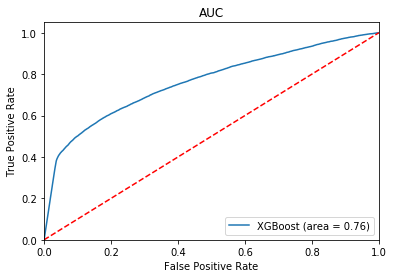

In [55]:
## Algorithm - 5 - Extreme Gradient Boost
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

param_test = {}

xtGb = GridSearchCV(estimator =  xgb.XGBClassifier(max_depth = 3, n_estimators = 300, learning_rate = 0.1, 
                                                  min_child_weight = 5, gamma = 0.1, subsample = 0.8), 
                   param_grid = param_test, scoring = 'roc_auc', n_jobs = 4, iid = False, cv = 10)

modelname='XGBoost'
x_features=['title_proximity_tfidf', 'description_proximity_tfidf',
       'main_query_tfidf', 'query_jl_score', 'query_title_score',
       'city_match_0.0','city_match_1.0', 'job_age_days','User_Item_Weightage','User_Weightage']

x_important_features = ['title_proximity_tfidf', 'description_proximity_tfidf',
       'main_query_tfidf', 'query_jl_score', 'query_title_score', 'job_age_days','User_Item_Weightage']

y_features=['apply']

#gbm = xgb.XGBClassifier(max_depth = 3, n_estimators = 300, learning_rate = 0.1)
xtGb.fit(data_train[x_important_features], data_train[y_features].values.ravel())
y_pred = xtGb.predict(data_test[x_important_features])
y_pred_prob = xtGb.predict_proba(data_test[x_important_features])[:, 1]
ModelEvaluation(modelname,data_test,y_pred,y_pred_prob)

C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


             precision    recall  f1-score   support

          0       0.95      0.88      0.91    105940
          1       0.30      0.51      0.38     10586

avg / total       0.89      0.85      0.87    116526

Printing Confusion Matrix...
[[93438 12502]
 [ 5150  5436]]
AUC Score..
0.748145887628
Classification Accuracy...
0.848514494619


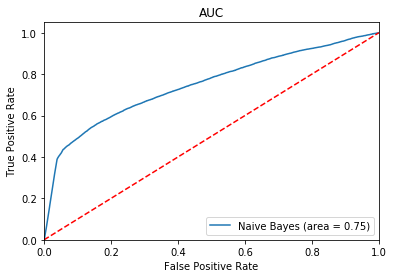

In [56]:
from sklearn.naive_bayes import GaussianNB
modelname='Naive Bayes'

x_features=['title_proximity_tfidf', 'description_proximity_tfidf',
       'main_query_tfidf', 'query_jl_score', 'query_title_score',
       'city_match_0.0','city_match_1.0', 'job_age_days','User_Item_Weightage','User_Weightage']

x_important_features = ['title_proximity_tfidf', 'description_proximity_tfidf',
       'main_query_tfidf', 'query_jl_score', 'query_title_score', 'job_age_days','User_Item_Weightage']

y_features=['apply']

nb = GaussianNB()

nb.fit(data_train[x_important_features], data_train[y_features]) 
y_pred = nb.predict(data_test[x_important_features])
y_pred_prob=nb.predict_proba(data_test[x_important_features])[:, 1]
ModelEvaluation(modelname,data_test,y_pred,y_pred_prob)